findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Avant Garde, sans-serif


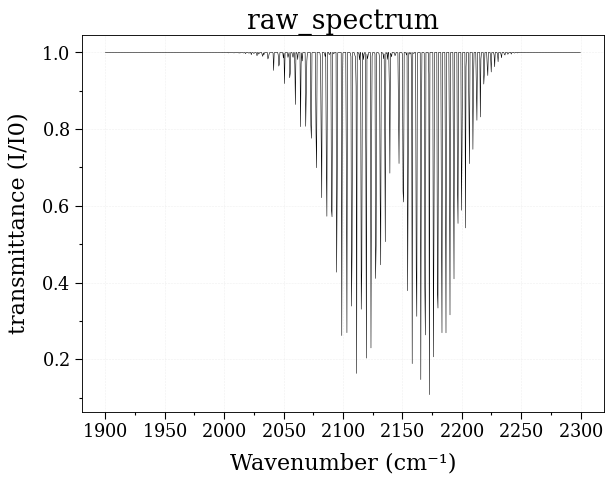

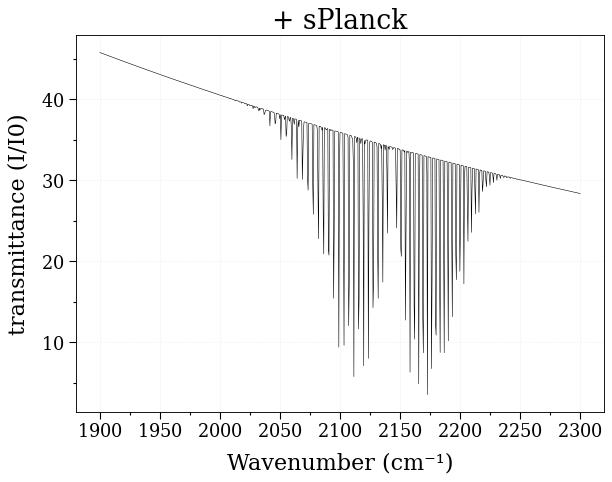

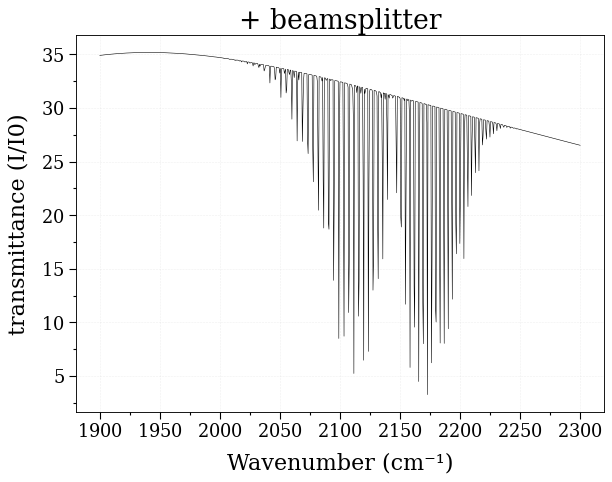

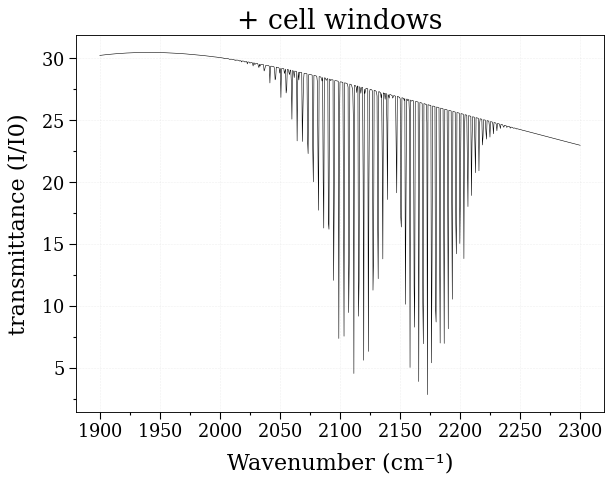

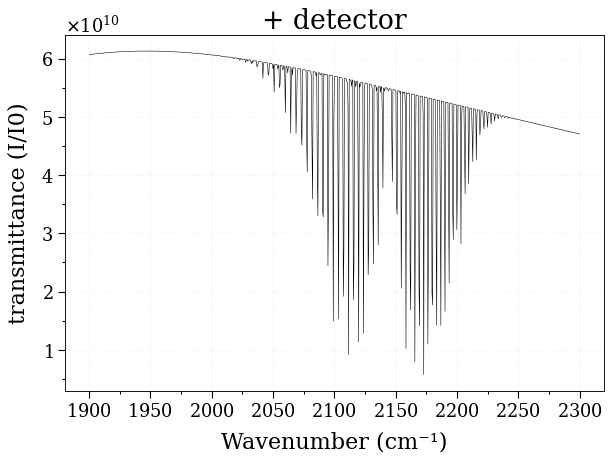

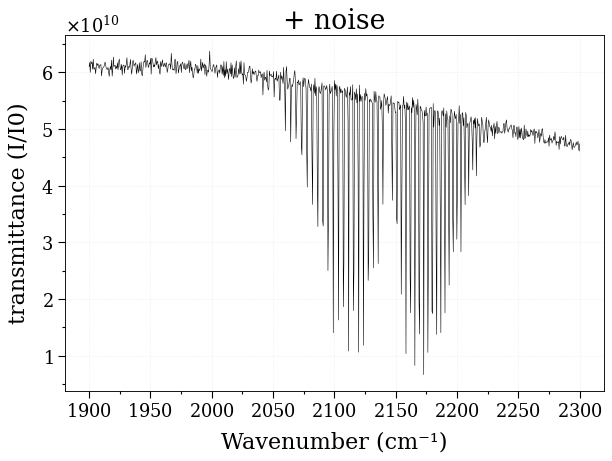

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from radis import SerialSlabs, Spectrum
from radis.spectrum.operations import add_array, multiply

from functions import (
    __MCT,
    __AR_CaF2,
    __AR_ZnSe,
    __CaF2,
    __generate_spectrum,
    __InSb,
    __param_check,
    __sapphire,
    __sPlanck,
    __ZnSe,
)


def main():
    # put incoming JSON into a dictionary
    params = {
        "minWave": 1900,
        "maxWave": 2300,
        "molecule": "CO",
        "pressure": 0.01,
        "resolution": 1,
        "numScan": 1,
        "zeroFill": 0,
        "source": 3100,
        "beamsplitter": "AR_ZnSe",
        "cellWindow": "CaF2",
        "detector": "MCT",
    }

    # verify user input is valid
    if not __param_check(params):
        return {
            "success": False,
            "text": "Parameter check failed",
        }

    # perform:
    #   --> transmission spectrum of gas sample (calc_spectrum)
    raw_spectrum, error, message = __generate_spectrum(params)
    if error:
        return {
            "success": False,
            "text": message,
        }

    raw_spectrum.plot("transmittance_noslit")
    plt.title("raw_spectrum")

    # ----- Pre-processing -----
    # generate the necessary spectra for blackbody, beamsplitters, cell windows, detectors. the spectra are generated based on the function provided in the call to the Spectrum constructor

    # returns the x-values of calc_spectrum() in an array
    #   https://radis.readthedocs.io/en/latest/source/radis.spectrum.spectrum.html#radis.spectrum.spectrum.Spectrum.get_wavenumber
    w = raw_spectrum.get_wavenumber()

    # processing for blackbody spectrum (sPlanck)
    spec_sPlanck = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __sPlanck(w, params["source"])},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="sPlanck",
    )

    # processing for anti-reflective zinc selenide (AR_ZnSe) beamsplitter
    spec_AR_ZnSe = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __AR_ZnSe(w)},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="AR_ZnSe",
    )

    # processing for anti-reflective calcium fluoride (AR_CaF2) beamsplitter
    spec_AR_CaF2 = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __AR_CaF2(w)},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="AR_CaF2",
    )

    # processing for calcium fluoride (CaF2) cell window
    spec_CaF2 = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __CaF2(w)},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="CaF2",
    )

    # processing for zinc selenide (ZnSe) cell window
    spec_ZnSe = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __ZnSe(w)},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="ZnSe",
    )

    # processing for sapphire window before detector
    spec_sapphire = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __sapphire(w)},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="sapphire",
    )

    # processing for Mercury-Cadmium-Telluride (MCT) detector
    spec_MCT = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __MCT(w)},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="MCT",
    )

    # processing for indium antimonide (InSb) detector
    spec_InSb = Spectrum(
        {"wavenumber": w, "transmittance_noslit": __InSb(w)},
        wunit="cm",
        units={"transmittance_noslit": ""},
        name="InSb",
    )

    # SerialSlabs() multiplies the transmittance values (y-values) of two provided spectra
    #   https://radis.readthedocs.io/en/latest/source/radis.los.slabs.html#radis.los.slabs.SerialSlabs
    # ----- b.) blackbody spectrum of source -----
    spectrum = SerialSlabs(raw_spectrum, spec_sPlanck)

    spectrum.plot("transmittance_noslit")
    plt.title("+ sPlanck")

    # ----- c.) transmission spectrum of windows/beamsplitter -----
    # ----- c.1) Beamsplitter -----
    match params["beamsplitter"]:
        case "AR_ZnSe":
            spectrum = SerialSlabs(spectrum, spec_AR_ZnSe)
        case "AR_CaF2":
            spectrum = SerialSlabs(spectrum, spec_AR_CaF2)

    spectrum.plot("transmittance_noslit")
    plt.title("+ beamsplitter")

    # ----- c.2) cell windows -----
    match params["cellWindow"]:
        case "CaF2":
            spectrum = SerialSlabs(spectrum, spec_CaF2)
            spectrum = SerialSlabs(spectrum, spec_CaF2)
        case "ZnSe":
            spectrum = SerialSlabs(spectrum, spec_ZnSe)
            spectrum = SerialSlabs(spectrum, spec_ZnSe)

    spectrum.plot("transmittance_noslit")
    plt.title("+ cell windows")

    # ----- d.) detector response spectrum -----
    match params["detector"]:
        case "MCT":
            spectrum = SerialSlabs(spectrum, spec_ZnSe)
            spectrum = SerialSlabs(spectrum, spec_MCT)
        case "InSb":
            spectrum = SerialSlabs(spectrum, spec_sapphire)
            spectrum = SerialSlabs(spectrum, spec_InSb)

    spectrum.plot("transmittance_noslit")
    plt.title("+ detector")

    # add random noise to spectrum
    #   https://radis.readthedocs.io/en/latest/source/radis.spectrum.operations.html#radis.spectrum.operations.add_array
    spectrum = add_array(
        spectrum,
        sum(np.random.normal(0, 800000000, (params["numScan"], len(w))))
        / params["numScan"],
        var="transmittance_noslit",
    )

    spectrum.plot("transmittance_noslit")
    plt.title("+ noise")


if __name__ == "__main__":
    main()